In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sts

In [5]:
df = pd.read_csv('[5]EPL_data_after_EDA.csv', index_col=0, parse_dates=['Date'])
df.head()

,Date,Time,Location,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AR,AvgH,AvgD,AvgA,Elo_HomeTeam,Elo_AwayTeam,Temperature,Humidity,Wind Speed,Condition
0,2024-04-25,20:00,EGKK,Brighton,Man City,0,4,A,0,3,...,0,6.568,4.890,1.426,1748.398682,2038.480591,44.750000,78.125000,5.687500,Fair
1,2024-04-24,20:00,EGCC,Man United,Sheffield United,4,2,H,1,1,...,0,1.304,6.056,8.154,1793.209839,1551.766602,44.979167,62.333333,7.062500,Mostly Cloudy
2,2024-04-24,20:00,EGGP,Everton,Liverpool,2,0,H,1,0,...,0,7.048,4.910,1.410,1692.962402,1923.581787,45.833333,65.523810,7.595238,Partly Cloudy
3,2024-04-24,20:00,EGLC,Crystal Palace,Newcastle,2,0,H,0,0,...,0,2.742,3.620,2.410,1708.831055,1811.576782,45.979167,59.250000,7.604167,Fair
4,2024-04-24,19:45,EGBB,Wolves,Bournemouth,0,1,A,0,1,...,1,2.698,3.586,2.476,1711.067993,1695.033447,43.958333,69.208333,6.520833,Fair


### Гипотезы

При разведочном анализе данных было построено много визуализаций для наших данных. После визуализации появились следующие гипотезы, которые нужно проверить:

1. __Главная:__ Команда, играющая дома, чаще побеждает
2. Команда, играющая дома, чаще бьет по воротам
3. Команда, играющая дома, чаще попадает по воротам
4. Команда, играющая дома, имеет больше угловых ударов
5. Команда, имеющая больший Elo rating, чаще побеждает
6. Команды, играющие дома и в гостях нарушают правило одинаковое количество раз
7. Команда, играющая дома, чаще получает желтые карточки
8. Температура, Влажность, Скорость ветра не влияют на количество голов 

### №1


(0.0, 50.0)

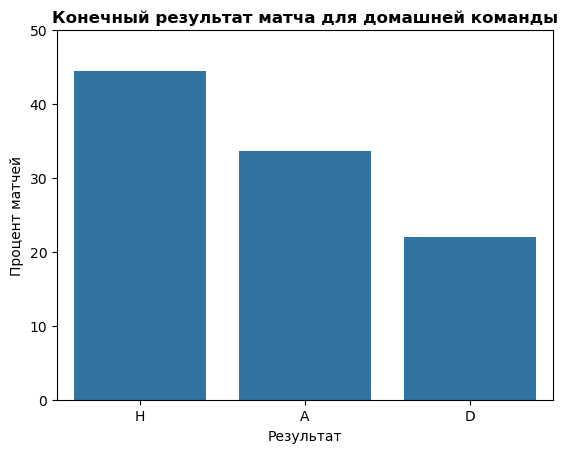

In [6]:
sns.countplot(data=df, x=df.FTR, order=df['FTR'].value_counts().index, stat='percent')

plt.xlabel('Результат')
plt.ylabel('Процент матчей')
plt.title('Конечный результат матча для домашней команды', weight='bold')
plt.ylim(0, 50)